In [1]:
import numpy as np
from calibration import placeinducingpoints, CalibrationSystem, EQ, SparseModel, Kernel
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Scaling Only Demo

Here we have four sensors, their calibration remains constant (although the model doesn't know that).

In [5]:
N = 501
X = np.linspace(0,260,N)[:,None]
X = np.c_[X,np.zeros(N),np.ones(N)]
Y = np.c_[np.linspace(20,40,N)[:,None],np.linspace(40,80,N)[:,None]]
Y[:,1]*=np.cos(X[:,0]/10)*0.2+1
Y[50:70,1]+=np.random.randn(20)*np.linspace(0,10,20)
Y[70:90,1]+=np.random.randn(20)*np.linspace(10,0,20)
Y[200:250,1]+=np.random.randn(50)*np.linspace(0,30,50)
Y[250:300,1]+=np.random.randn(50)*np.linspace(30,0,50)
Y[:,1]+=np.random.randn(N)*np.linspace(3,0,N)
refsensor = np.array([1,0])
Z = np.linspace(0,260,50)[:,None]

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd

In [155]:
def transform_fn(samps,Y):
    return Y*(1+samps[:,:,0:1])

count=0
class NewCalSys(CalibrationSystem):
    def __init__(self,X,Y,Z,refsensor,C,transform_fn,gpflowkernel,likemodel='fixed',gpflowkernellike=None,likelihoodstd=1.0,jitter=1e-3):
        """
        likemodel specifies how the likelihood is modelled, it can be one of three values:
          - fixed [default, uses the value in likelihoodstd]
          - single [optimise a single value [TODO Not Implemented]]
          - distribution [uses gpflowkernellike]
          - process [uses gpflowkernellike]
        """
        self.likemodel = likemodel
        S = len(refsensor)
        self.C = C
        self.Y = Y        
        self.k = Kernel(gpflowkernel)
        
        self.likelihoodstd = likelihoodstd
        self.X = np.c_[np.tile(np.r_[np.c_[X[:,0],X[:,1]],np.c_[X[:,0],X[:,2]]],[self.C,1]),np.repeat(np.arange(self.C),2*len(X))]        
        
        if Z.shape[1]==1:
            Ztemp = np.c_[np.tile(Z,[S,1]),np.repeat(np.arange(S),len(Z))]
        if Z.shape[1]==2:
            Ztemp = Z
        self.Z = np.c_[np.tile(Ztemp,[C,1]),np.repeat(np.arange(self.C),len(Ztemp))]        
        
        
        if likemodel=='distribution' or likemodel=='process':
            assert gpflowkernellike is not None, "You need to specify the kernel to use a distribution or process"
            self.klike = Kernel(gpflowkernellike)
            self.Xlike = np.c_[np.r_[np.c_[X[:,0],X[:,1]],np.c_[X[:,0],X[:,2]]],np.repeat(0,2*len(X))]
            self.Zlike = np.c_[Ztemp,np.repeat(0,len(Ztemp))]
            
        self.N = N = len(X)
        self.refsensor = refsensor.astype(np.float32)
        self.jitter = jitter
        self.transform_fn = transform_fn        
        self.precompute()
        
    def precompute(self):    
        #definition of q(u)
        M = self.Z.shape[0]
        self.mu = tf.Variable(0.001*tf.random.normal([M,1]))
        self.scale = tf.Variable(0.1*np.tril(0.1*np.random.randn(M,M)+0.1*np.eye(M)),dtype=tf.float32)
        
        
        
        if self.likemodel=='distribution' or self.likemodel=='process':
            Mlike = self.Zlike.shape[0]
            self.mulike = tf.Variable(0.0001*tf.random.normal([Mlike,1]))
            mu_u = tf.Variable(np.full([Mlike],-12),dtype=tf.float32)
            cov_u = tf.Variable(self.klike.matrix(self.Zlike,self.Zlike),dtype=tf.float32)
            self.pulike = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*self.jitter)
            self.likeoptimizer = tf.keras.optimizers.Adam(learning_rate=0.08,amsgrad=False) #0.8
            self.smlike = SparseModel(self.Xlike,self.Zlike,1,self.k)
        else:
            self.mulike = None
        if self.likemodel=='process':
            self.scalelike = tf.Variable(1e-10*np.eye(Mlike),dtype=tf.float32)
        else:
            self.scalelike = None
        
        #parameters for p(u)
        mu_u = tf.zeros([M],dtype=tf.float32)
        cov_u = tf.Variable(self.k.matrix(self.Z,self.Z),dtype=tf.float32)
        self.pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*self.jitter)
        self.ref = tf.gather(self.refsensor,tf.transpose(tf.reshape(self.X[:(2*self.N),1:2].astype(int),[2,self.N])))
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.02,amsgrad=False) #0.2
        self.sm = SparseModel(self.X,self.Z,self.C,self.k)
        
    def likelihoodfn_nonstationary(self,scaledA,scaledB,varparamA,varparamB):
        return tfd.Normal(0,0.00001+tf.sqrt(tf.exp(varparamA)+tf.exp(varparamB))).log_prob(scaledA-scaledB)    
    
    def likelihoodfn(self,scaledA,scaledB):
        return tfd.Normal(0,self.likelihoodstd).log_prob(scaledA-scaledB)
        
    #@tf.function
    def run(self,its=None,samples=100,threshold=1.0):
        """Set its to None to automatically stop
        when the ELBO has reduced by less than threshold
        (between rolling averages of the last 50 calculations
        and the 50 before that)"""
        elbo_record = []
        it = 0
        while (its is None) or (it<its):
            it+=1
            with tf.GradientTape() as tape:
                qu = tfd.MultivariateNormalTriL(self.mu[:,0],self.scale)
                samps = self.sm.get_samples(self.mu,self.scale,samples)
                scaled = tf.concat([self.transform_fn(samps[:,:,::2],self.Y[:,0:1]),self.transform_fn(samps[:,:,1::2],self.Y[:,1:2])],2)
                scaled = (scaled * (1-self.ref)) + (self.Y * self.ref)
                
                if self.mulike is not None: #if we have non-stationary likelihood variance...
                    qulike = tfd.MultivariateNormalTriL(self.mulike[:,0],self.scalelike)              
                    like = self.smlike.get_samples(self.mulike,self.scalelike,samples)
                    ell = tf.reduce_mean(tf.reduce_sum(self.likelihoodfn_nonstationary(scaled[:,:,0],scaled[:,:,1],like[:,:,0]*(1-self.ref[:,0])-1000*self.ref[:,0],like[:,:,1]*(1-self.ref[:,1])-1000*self.ref[:,1]),1))
                else: #stationary likelihood variance
                    ell = tf.reduce_mean(tf.reduce_sum(self.likelihoodfn(scaled[:,:,0],scaled[:,:,1]),1))
                
                elbo_loss = -ell+tfd.kl_divergence(qu,self.pu)
                
                if self.likemodel=='process':
                    assert self.mulike is not None
                    assert self.scalelike is not None
                    elbo_loss += tfd.kl_divergence(qulike,self.pulike)
                if self.likemodel=='distribution':
                    assert self.mulike is not None
                    elbo_loss -= self.pulike.log_prob(self.mulike[:,0])

                if it%100==0: print("%d (ELBO=%0.4f)" % (it, elbo_loss))
                
                if (self.mulike is None) or (it%50<25): #optimise latent fns
                    gradients = tape.gradient(elbo_loss, [self.mu,self.scale])
                    self.optimizer.apply_gradients(zip(gradients, [self.mu, self.scale]))  
                else: #this optimises the likelihood...
                    if self.likemodel=='distribution':
                        gradients = tape.gradient(elbo_loss, [self.mulike])
                        self.likeoptimizer.apply_gradients(zip(gradients, [self.mulike]))
                    if self.likemodel=='process':
                        gradients = tape.gradient(elbo_loss, [self.mulike,self.scalelike])
                        self.likeoptimizer.apply_gradients(zip(gradients, [self.mulike,self.scalelike]))

                elbo_record.append(elbo_loss)
            if its is None:
                if it>100:
                    oldm = np.mean(elbo_record[-100:-50])
                    m = np.mean(elbo_record[-50:])
                    if np.abs(oldm-m)<threshold:
                        break
        return np.array(elbo_record)

In [152]:
k = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
klike = gpflow.kernels.RBF(100,20)+gpflow.kernels.Bias(100)
cs = NewCalSys(X, Y, Z, refsensor, 1, transform_fn, k, likemodel='process',gpflowkernellike=klike,likelihoodstd=0.5)
import time
before = time.time()
elbo_record = cs.run()
print(time.time()-before)

100 (ELBO=3706.1814)
200 (ELBO=2618.0981)
300 (ELBO=2290.3467)
400 (ELBO=2124.2119)
500 (ELBO=2029.4128)
600 (ELBO=1980.2753)
700 (ELBO=1947.4501)
800 (ELBO=1923.8267)
98.63077545166016


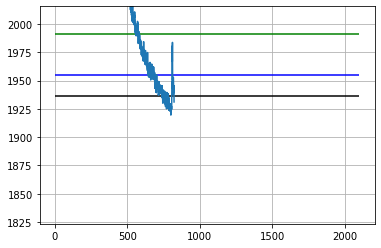

In [156]:
plt.plot(elbo_record)
plt.grid()
#plt.yscale('log')
plt.ylim([np.min(elbo_record)*0.95,np.min(elbo_record)*1.05])
plt.hlines(np.mean(elbo_record[-100:]),0,2100,'k')
plt.hlines(np.mean(elbo_record[-200:-100]),0,2100,'b')
plt.hlines(np.mean(elbo_record[-300:-200]),0,2100,'g')
plt.hlines(np.mean(elbo_record[-400:-300]),0,2100,'r')
plt.hlines(np.mean(elbo_record[-500:-400]),0,2100,'y')

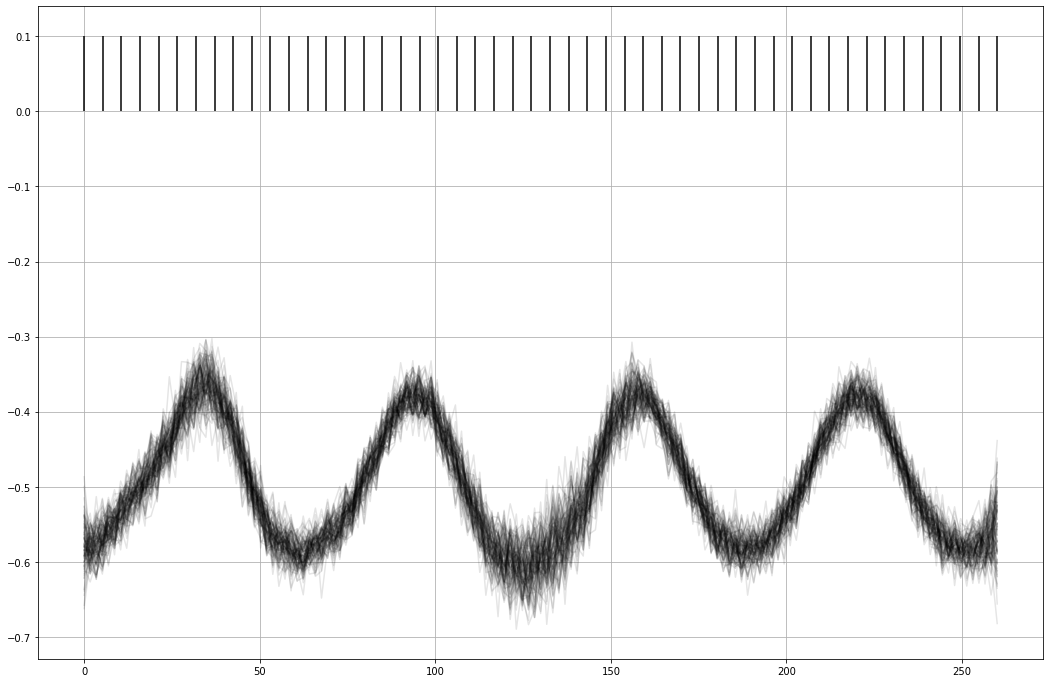

In [157]:
#build test matrix
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,260,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    

    plt.figure(figsize=[18,12])
    plt.plot(x,(samps[::,:,0].numpy().T),'k-',alpha=0.1);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],0,.1)
    #plt.ylim([-.2,1.2])

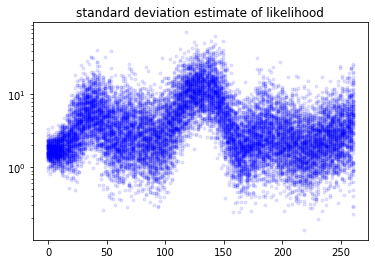

In [158]:
plt.title('standard deviation estimate of likelihood')
plt.plot(x,np.sqrt(np.exp(sampslike[:,:,0].numpy().T)),'b.',alpha=0.1);
plt.gca().set_yscale('log')
#plt.ylim([1e-3,1])

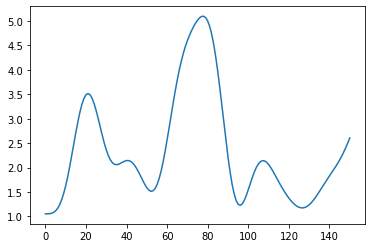

In [159]:
plt.plot(qf_mulike.numpy())

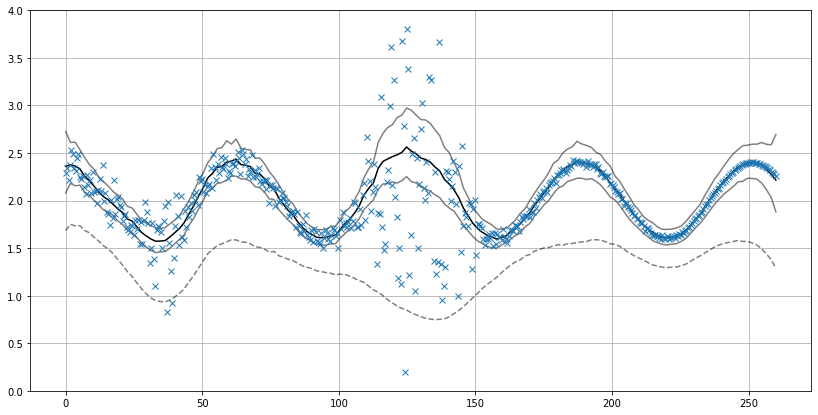

In [161]:
plt.figure(figsize=[14,7])
plt.plot(x,1/(1+qf_mu[:151,0]),'k-')
#plt.plot(x,1/(1+qf_mu[:151,0])+2*np.sqrt(np.diag(qf_cov)[:151])+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
#plt.plot(x,1/(1+qf_mu[:151,0])-2*np.sqrt(np.diag(qf_cov)[:151])-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0]),'k--',alpha=0.5)
plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
plt.plot(x,1/(1+(qf_mu[:151,0]-2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)
plt.plot(x,1/(1+(qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))),'k-',alpha=0.5)

plt.plot(X[:,0],Y[:,1]/Y[:,0],'x')
plt.ylim([0,4])
plt.grid()


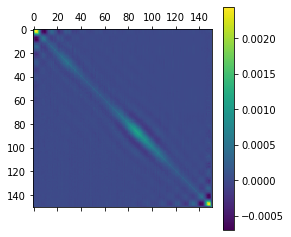

In [60]:
plt.matshow(qf_cov)
plt.colorbar()

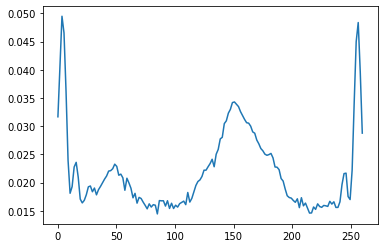

In [61]:
plt.plot(x,np.sqrt(np.diag(qf_cov)[:151]))


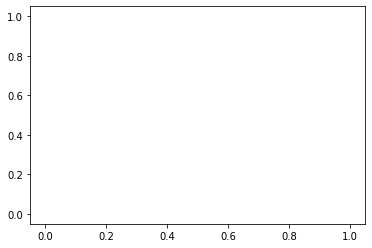

In [20]:
plt.plot(np.sqrt(np.exp(qf_mu[151:,0])))
#plt.ylim([0,20])

## Linear transform demo

Just two sensors, the low-cost sensor has a drift in which its offset increases over time.

There is obviously some ambiguity from the model's point of view as to whether the difference between the sensors is due scaling or offset.

In [193]:
X = np.c_[np.linspace(0,20,21),np.zeros(21),np.ones(21)]
y = np.cos(X[:,0])*25+100
Y = np.c_[y,y+X[:,0]]
refsensor = np.array([1,0])
Z = np.linspace(0,20,5)[:,None]

In [194]:
#def transform_fn(samps,Y):
#    return 100*(samps[:,:,0:1]) + Y*samps[:,:,1:2] + (samps[:,:,2:3]*Y**2)/1000

def transform_fn(samps,Y):
    return 100*samps[:,:,0:1] + Y*samps[:,:,1:2]

k = gpflow.kernels.RBF(1,15)+gpflow.kernels.Bias(1)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=0.05)
cs.run(its=1000)

AttributeError: 'CalibrationSystem' object has no attribute 'likelihoodfn'

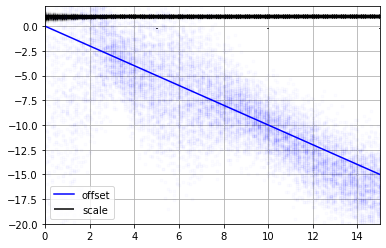

In [40]:
#build test matrix
C = 2
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,15,151)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k))
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)

    plt.figure(figsize=[6,4])
    plt.plot(x,samps[:,:,1].numpy().T,'k.',alpha=0.01);
    plt.plot(x,100*samps[:,:,0].numpy().T,'b.',alpha=0.01);
    #plt.plot(-getsensorshift(x,np.ones_like(x).astype(int)))
    plt.grid()
    plt.vlines(Z[:,0],-.3,-.2)
    plt.ylim([-20,2])
    plt.xlim([0,15])
    plt.hlines(1,0,15,'k',label='scale')
    plt.plot([0,15],[0,-15],'b-',label='offset')
    plt.legend(loc='lower left')